# Minimum-entropy fit of the isochrone potential

Here we fit a gravitational potential of the isochrone model using the kinematics of a sample in equilibrium in the correct potential.
The physical basis of the method is exposed in [Beraldo e Silva et al. (2025)](https://ui.adsabs.harvard.edu/abs/2024arXiv240707947B/abstract).

This code uses the [agama](https://github.com/GalacticDynamics-Oxford/Agama) package to generate an equilibrium sample and to estimate the potential and action-variables, but any other library, such as [gala](http://gala.adrian.pw/en/latest/) or [galpy](https://www.galpy.org/), or personal code could be used for these tasks instead.

In [5]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 60
import tropygal
import agama

from matplotlib.ticker import ScalarFormatter, NullFormatter

params = {'axes.labelsize': 24, 
          'xtick.labelsize': 20, 
          'xtick.direction': 'in',
          'xtick.major.size': 8.0,
          'xtick.bottom': 1,
          'xtick.top': 1,
          'ytick.labelsize': 20, 
          'ytick.direction': 'in',
          'ytick.major.size': 8.0,
          'ytick.left': 1,
          'ytick.right': 1,
#           'xtick.which': 'both',
          'text.usetex': True, 
          'lines.linewidth': 1,
          'axes.titlesize': 32,
          'font.family': 'serif'}
plt.rcParams.update(params)
columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
# %matplotlib qt
# %matplotlib widget
# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

## Function to return entropy

In [6]:
def func_S_J(params, pos, vel, k=1):
    """ 
    Returns the entropy of the sample in each trial potential.
    It uses agama to estimate the potential and action-variables
 
    Parameters
    ---------- 
    params: array
            parameters of the trial potential
    pos: array
         (x, y, z) spatial coordinates
    vel: array
         (vx, vy, vz) velocity coordinates
    k: int
       kNN, which neighbor to take

    Returns
    -------
    float number
    The entropy of the sample assuming the DF is a function of actions
   
    """

    M, b = params
    prior = (M > 0) & (b>0)
    if (prior == False):
        return np.inf

    pot = agama.Potential(type='Isochrone', mass=M, scaleRadius=b)
    v2 = vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2
    E = pot.potential(pos) + 0.5*v2

    # Only consider models where all particles are bound
    if np.all(E<0):
        actF = agama.ActionFinder(pot) # action finder
        coords = np.column_stack([pos, vel])
        # calc actions: 
        J = actF(coords, actions=True, frequencies=False, angles=False)
        sigma_J = np.array([0.5*(np.percentile(action, 84) - np.percentile(action, 16)) for action in J.T])
        S_J = tropygal.entropy(J/sigma_J, mu=_2pi3*np.prod(sigma_J), k=k, correct_bias=True)
        return S_J
    else:
        return np.inf

## Generate IC

In [7]:
_2pi3 = (2.*np.pi)**3
print ('agama.G:', agama.G)

# True values of parameters:
M0 = 1. # total mass
b0 = 1. # scale length

n_orbs = int(10_000*10./7)
n_boots = 100
#n_boots = 10_000 

# Generate IC 
pot_0 = agama.Potential(type='Isochrone', mass=M0, scaleRadius=b0)
isoc_data, _ = pot_0.sample(n_orbs, potential=pot_0)

x  = isoc_data[:,0]; y  = isoc_data[:,1]; z  = isoc_data[:,2]
vx = isoc_data[:,3]; vy = isoc_data[:,4]; vz = isoc_data[:,5]

v2 = vx**2 + vy**2 + vz**2
pos = np.column_stack((x, y, z))
E = pot_0.potential(pos) + 0.5*v2

agama.G: 1.0


## Select 70% more bound stars

In [4]:
# This is just to probe a larger range of parameters, 
# since we only consider models where all particles are bound
E_cut = np.percentile(E, 70)
cut = E<E_cut

x  = x[cut];  y  = y[cut];  z  = z[cut]
vx = vx[cut]; vy = vy[cut]; vz = vz[cut]
E = E[cut]

pos = pos[cut]
vel = np.column_stack((vx, vy, vz))
v2 = v2[cut]

data_0 = np.column_stack((pos, vel))

## Define parameters and bins

In [5]:
kNN = 10 # which neighbor we take
print ('kNN:', kNN)

# Bins for initial guess of parameters in the minimization
nbins_M0 = 4
nbins_b0 = 4

M0_min = 0.1
M0_max = 5
b0_min = 0.1
b0_max = 5

bin_edges_M0 = np.linspace(M0_min, M0_max, nbins_M0+1)
bins_M0 = 0.5*(bin_edges_M0[:-1] + bin_edges_M0[1:])
d_M0 = bin_edges_M0[1] - bin_edges_M0[0]

bin_edges_b0 = np.linspace(b0_min, b0_max, nbins_b0+1)
bins_b0 = 0.5*(bin_edges_b0[:-1] + bin_edges_b0[1:])
d_b0 = bin_edges_b0[1] - bin_edges_b0[0]

p0 = np.stack(np.meshgrid(bins_M0, bins_b0), -1).reshape(-1, 2)

p_bf = np.full((n_boots+1, 2), np.nan) # best fit params for each bootstrap 
S_bf = np.full(n_boots+1, 1e+18) # best fit entropy for each bootstrap

kNN: 10


## Fit for original and each bootstrap sample

In [6]:
# Do minimum-entropy fit for single sample, but several times, each bootstrap at a time:
for i in range(n_boots+1):
    print ('------------------')
    print ('Starting bootstrap ', i)
    if (i==0): # For the first, it's the orifinal dataset
        data = data_0.copy()
    else: # otherwise, bootstrap:
        data = data_0[np.random.choice(len(data_0), size=len(data_0), replace=True)]

    x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
    vx = data[:,3]; vy = data[:,4]; vz = data[:,5]

    v2 = vx**2 + vy**2 + vz**2
    pos = np.column_stack((x, y, z))
    vel = np.column_stack((vx, vy, vz))
    # ----------------------------  
    p_J = np.zeros_like(p0)
    S_J = np.full(len(p0), 1e+18)
    func_evals_J = np.zeros(len(p0))
    # ----------------------------  
    for j in range(len(p0)): 
        this_M0 = p0[j, 0]
        this_b0 = p0[j, 1]
        pot = agama.Potential(type='Isochrone', mass = this_M0, scaleRadius = this_b0)
        # only consider models with initial guess of parameters where all particles are bound:
        E = pot.potential(pos) + 0.5*v2
        if np.all(E < 0):
            initial_simplex = [p0[j],                         # First vertex: the initial guess
                               p0[j] + [this_M0 + d_M0, 0],   # Second vertex: offset x[0] by d_M0 
                               p0[j] + [0, this_b0 + d_b0]]
            res = optimize.minimize(func_S_J, p0[j], args=(pos, vel, kNN),
                                    method='Nelder-Mead',
                                    options={'initial_simplex': initial_simplex, "maxfev":500, "xatol":1e-3, "fatol":1e-3}) # Downhill Simplex for Max Likelihood 
            # Best fit for this initial guess, and for this bootstrap sample: 
            p_J[j] = res.x
            S_J[j] = res.fun
            func_evals_J[j] = res.nfev
    idx_min = S_J.argmin()
    # best fit among all initial guesses, for this bootstrapped sample:
    p_bf[i] = p_J[idx_min]
    print ('p_bf:', p_bf[i])

    S_bf[i] = S_J[idx_min]
    print ('S_bf:', S_bf[i])

------------------
Starting bootstrap  0
p_bf: [0.99576392 1.00270952]
S_bf: 5.073541012150839
------------------
Starting bootstrap  1
p_bf: [1.08400619 1.13913031]
S_bf: 4.970057277766899
------------------
Starting bootstrap  2
p_bf: [1.1252395  1.10610378]
S_bf: 4.927894468910267
------------------
Starting bootstrap  3
p_bf: [0.94014059 0.9368894 ]
S_bf: 4.97174618516169
------------------
Starting bootstrap  4
p_bf: [0.97751758 0.99958386]
S_bf: 4.957546773525614
------------------
Starting bootstrap  5
p_bf: [0.98280102 0.98452787]
S_bf: 4.947722113428504
------------------
Starting bootstrap  6
p_bf: [1.0637083  1.10865897]
S_bf: 4.97933441388985
------------------
Starting bootstrap  7
p_bf: [0.98781657 1.00647091]
S_bf: 4.949427183381747
------------------
Starting bootstrap  8
p_bf: [1.06532282 1.11683046]
S_bf: 4.971205997219309
------------------
Starting bootstrap  9
p_bf: [0.96811743 0.96937001]
S_bf: 4.956687745893135
------------------
Starting bootstrap  10
p_bf: [1.0

## Best fit results

In [21]:
#print ('p_bf:', p_bf)
#print ('S_bf:', S_bf)

# Best fit averaging over all data realizations (bootstraps):
print ('<M>:', np.percentile(p_bf[:,0], 50), '±', 0.5*(np.percentile(p_bf[:, 0], 84) - np.percentile(p_bf[:, 0], 16)))
print ('<b>:', np.percentile(p_bf[:,1], 50), '±', 0.5*(np.percentile(p_bf[:, 1], 84) - np.percentile(p_bf[:, 1], 16)))

<M>: 0.9822197081959251 ± 0.05933260541227614
<b>: 0.9987393008313783 ± 0.08275546736809447


## Save best fit results

In [8]:
# Save best fit parameters for each bootstrap data realization: 

# file_name = './fit_results_isoc_boots_k10.dat'
# file_out = open(file_name, 'w')
# file_out.write('#       M_bf             b_bf         S_bf\n')
# np.savetxt(file_out, np.column_stack([p_bf[:,0], p_bf[:,1], S_bf]), fmt=' %17.8e'*3)
# file_out.close()

## Plot

In [23]:
#fname = './fit_results_isoc_boots_k10.dat'
# data_file = np.genfromtxt(fname, unpack=True, skip_header=1)
# M_bfs = data_file[0]
# b_bfs = data_file[1]
# S_bfs = data_file[2]

M_bfs = p_bf[:,0]
b_bfs = p_bf[:,1]
# Original data:
M_0 = p_bf[0,0]
b_0 = p_bf[0,1]
print ('Original data:')
print ('M_0:', M_0)
print ('b_0:', b_0)

# bootstraps:
mean_M = np.percentile(M_bfs, 50)
sigma_M = 0.5*(np.percentile(M_bfs, 84) - np.percentile(M_bfs, 16))

mean_b = np.percentile(b_bfs, 50)
sigma_b = 0.5*(np.percentile(b_bfs, 84) - np.percentile(b_bfs, 16))
print('-------')
print('Bootstraps:')
print ('M_bf:', mean_M, '±', sigma_M)
print ('b_bf:', mean_b, '±', sigma_b)

print (len(M_bfs), 'fits')

Original data:
M_0: 0.9957639204643787
b_0: 1.002709517712356
-------
Bootstraps:
M_bf: 0.9822197081959251 ± 0.05933260541227614
b_bf: 0.9987393008313783 ± 0.08275546736809447
101 fits


In [10]:
M_min = 0.5
M_max =1.5
b_min = 0.5
b_max = 1.5

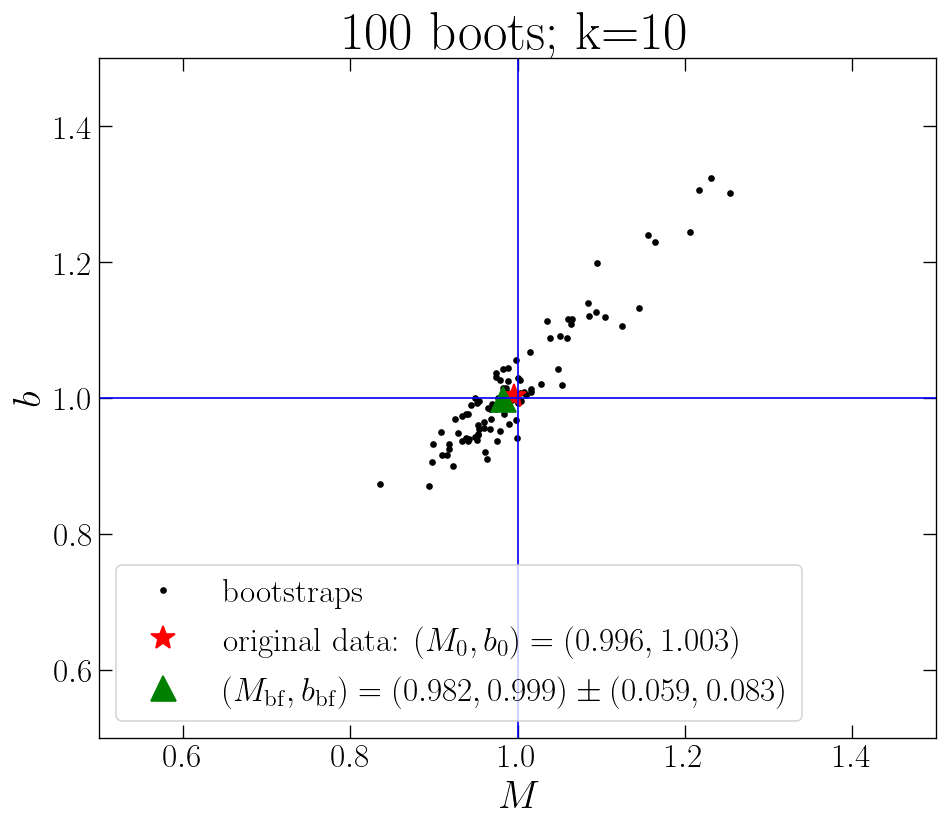

In [26]:
# Plot
fig, axs = plt.subplots(1, figsize=(8,7))
fig.patch.set_facecolor('white')

axs.plot(M_bfs, b_bfs, 'k.', label='bootstraps')
axs.plot(M_bfs[0], b_bfs[0], 'r*', ms=15, 
         label=r'original data: $(M_\mathrm{0}, b_\mathrm{0}) = (%.3f, %.3f)$'%(M_0, b_0))
axs.plot(mean_M, mean_b, 'g^', ms=15,
         label=r'$(M_\mathrm{bf}, b_\mathrm{bf}) = (%.3f, %.3f) \pm (%.3f, %.3f)$'%(mean_M, mean_b, sigma_M, sigma_b))
axs.axvline(1, color='b', linewidth=1, linestyle='-')
axs.axhline(1, color='b', linewidth=1, linestyle='-')

axs.axis([M_min, M_max, b_min, b_max])
axs.set_xlabel(r'$M$')
axs.set_ylabel(r'$b$')

axs.set_title(r'%d boots; k=%d'%(n_boots, kNN))
axs.legend(fontsize=20)
plt.tight_layout()

plt.show()